# Gas Material Balance to Estimate IGIP



In [144]:
import math
import numpy as np
import pandas as pd
from sympy import var, solveset, S
from sympy import *
from sympy import Symbol
from scipy import interpolate
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.patches as mpl_patches

In [145]:
def initial_hydrocarbon_in_place(Gfgi, Rs):
  Rsi = Rs[0]
  OGIP = Gfgi + Nfoi * Rsi

  labels = []
  labels.append('IGIP = {0:.4f} MMSCF'.format(OGIP))

  return labels, OGIP

In [146]:
def zBB(SG, P, T):
  Tpc = 170.491 + 307.344*SG
  Ppc = 709.64 - 58.718*SG
  Pr = P/Ppc
  Tr = (T+459.67)/Tpc
  A = 1.39*(Tr-0.92)**0.5-0.36*Tr-0.101
  A1 = (1-(1.39*(Tr-0.92)**0.5-0.36*Tr-0.101))/math.exp((0.62-0.23*Tr)*Pr+(0.066/(Tr-0.86)-0.037)*Pr**2+0.32/10**(9*(Tr-1))*Pr**6)
  A2 = (0.132-0.32*math.log(Tr,10))*Pr**(10**(0.3106-0.49*Tr+0.1824*Tr**2))
  return(A+A1+A2)

In [147]:
T = 210 #Farenheit
SG = 0.75
p = np.array([3500, 3000, 2500, 2000, 1500])
Gp = np.array([0, 218, 461, 725, 1000])
z =[]
Bg =[]
for i in range (len(p)):
  z_corr = zBB(SG, p[i], T)
  Bg.append(0.0283* z_corr*(T+459.67)/p[i])
  z.append(z_corr)
pi = p[0]
Bgi = Bg[0]
# total gas FVF equals the gas FVF itself (for dry-gas)
Btg = Bg

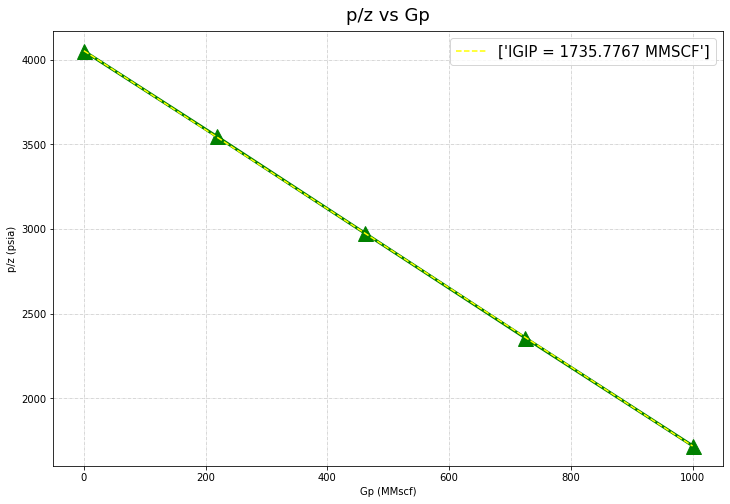

In [148]:
# no volatile and vapor component, define Rv as zeros
Rv, Rs = np.zeros(len(p)), np.zeros(len(p))

# plot attributes
title_size = 12
title_pad = 10

# linear function for curve-fit
def linear_zero_intercept(x, m):
  y = m * x
  return y

def linear_with_intercept(x, m, c):
  y = m * x + c
  return y
# Plot: p/z vs Gp
fig, ax = plt.subplots(figsize =(12, 8))
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
x, y = Gp, (p/z)
plt.plot(x, y, '.-',linewidth=3, color = 'green', markersize = '15', marker='^')
plt.title('p/z vs Gp', size=18, pad=title_pad)
plt.xlabel('Gp (MMscf)')
plt.ylabel('p/z (psia)')

## curve-fitting to calculate the slope as OGIP
x_norm = x / max(x) # normalize x
y_norm = y / max(y) # normalize y
popt, pcov = curve_fit(linear_with_intercept, x_norm, y_norm)

m, c = popt[0], popt[1]
Gfgi = (-c / m) * max(x) # OGIP is the intercept at x-axis, and denormalized
m = m * max(y) / max(x) # denormalize the slope
c = c * max(y) # denormalize the intercept

## Output results into text in plot
Nfoi = 0
labels, OGIP = initial_hydrocarbon_in_place(Gfgi, Rs)         

## plot the regression line
x_fit = np.linspace(min(x), max(x), 5)
y_fit = linear_with_intercept(x_fit, m, c)
# ay = ax.plot(x_fit, y_fit)
line2, = plt.plot(x_fit, y_fit, label=labels, color = 'yellow', linestyle = '--')
# plt.legend(labels, fontsize='large', 
#            framealpha=0.8, 
#             handlelength=0, handletextpad=0)
plt.legend(handles=[line2],fontsize='15')
plt.show()

In [149]:
F = []; Eg = []
for i in range(len(p)):
    F_ = Bg[i] * Gp[i] *1000000
    Eg_ = Btg[i] - Bgi
    F.append(F_); Eg.append(Eg_)
F = np.array(F); Eg = np.array(Eg)

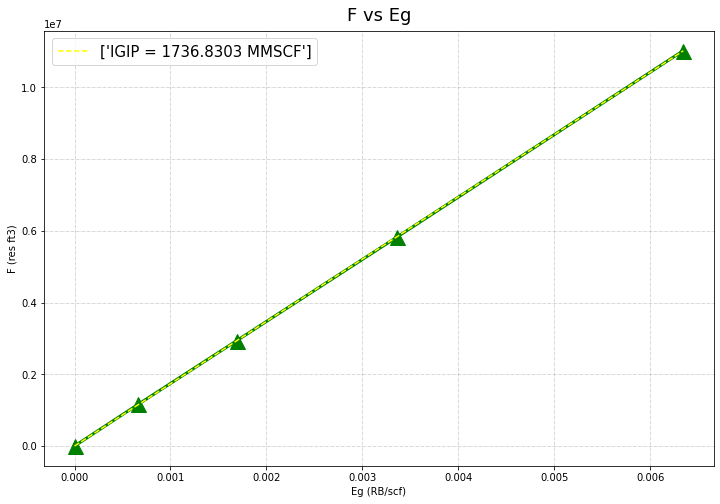

In [157]:
fig, ax1 = plt.subplots(figsize =(12, 8))
ax1.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
x1, y1 = Eg, F
plt.plot(x1, y1, '.-', linewidth=3, color = 'green', markersize = '15', marker='^')
plt.title('F vs Eg', size=18, pad=title_pad)
plt.xlabel('Eg (RB/scf)')
plt.ylabel('F (res ft3)')
# fig, ax1 = plt.subplots(figsize =(14, 8))
# curve-fitting to calculate the slope as OGIP
x1_norm = x1 / max(x1) # normalize x
y1_norm = y1 / max(y1) # normalize y
popt, pcov = curve_fit(linear_zero_intercept, x1_norm, y1_norm)

m = popt[0]
Gfgi = m * max(y1) / max(x1) # denormalize the slope, hence the OGIP

## Output results into text in plot
labels, OGIP = initial_hydrocarbon_in_place(Gfgi/1000000, Rs) 

## plot the regression line
x1_fit = np.linspace(min(x1), max(x1), 5)
y1_fit = linear_zero_intercept(x1_fit, Gfgi)
line1, = plt.plot(x1_fit, y1_fit, label=labels, color = 'yellow', linestyle = '--')
plt.legend(handles=[line1],fontsize='15')
plt.show()